### Create the function of velocity of the blood

In [75]:
import sys
import os
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

from simulation import pw_us, heart_rate
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft
import scipy.signal as ss
plt.style.use('seaborn-whitegrid')

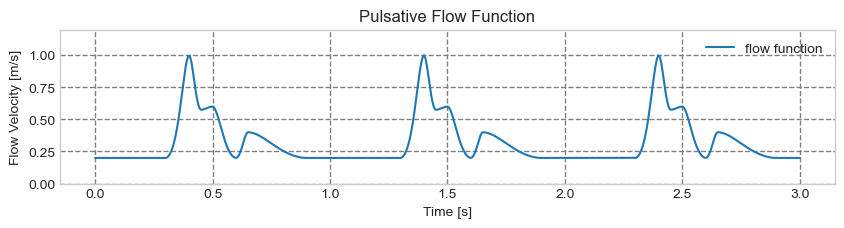

In [2]:
flow_function_cyclic = heart_rate.HeartRateWave(60)
# Returns evenly spaced numbers over a specified interval.
X = np.linspace(0, 3, 500)
Y = flow_function_cyclic(X)

# Draw the plot
plt.figure(figsize=(10,2))
plt.plot(X, Y, '-')
plt.legend(['flow function'], loc = 'best')
plt.title("Pulsative Flow Function")
plt.xlabel("Time [s]")
plt.ylabel("Flow Velocity [m/s]")
plt.ylim([0,1.2])
plt.grid(color='gray', linestyle='--', linewidth=1)
plt.show()

In [3]:
f_0 = 2.25e6
display(f_0)
v_max = 1.5
v_min = 0.01
c=1540
theta=60
f_d_max = 2*np.cos(theta*np.pi/180)*v_max/c*f_0
display(f_d_max)
prf = max(5e3,f_d_max)
display(prf)
delta_f = 2*np.cos(theta*np.pi/180)*v_min/c*f_0
display(delta_f)
T = 1/2/delta_f
display(T)

2250000.0

2191.558441558442

5000.0

14.610389610389612

0.034222222222222216

f =  1482.5581395348836 [Hz]; v =  1.0147286821705424 [m/s]
f =  1482.5581395348836 [Hz]; v =  1.0147286821705424 [m/s]


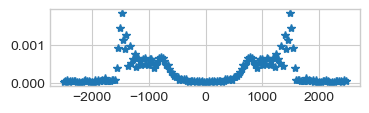

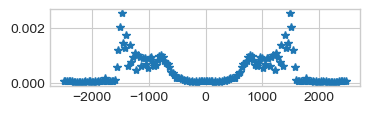

In [145]:
start_time = .4-T/2
sim = pw_us.SimulationPWUS(f_0=f_0, t_max=T, n_period=2, prf=prf, 
                           d=10e-3, theta_deg=theta, windowing="rect", 
                           digital_sample_f=3*f_0+3*f_d_max)  

echo, I, Q, t_sample, I_sampled, Q_sampled = sim.simulate(lp_cutoff=f_d_max*30,noise_std=0.005, start_time=start_time)
t=sim.t

def get_fft(time, y):
    freq = np.fft.fftfreq(len(time), d=time[1]-time[0])
    df = freq[1]-freq[0]
    spectrum = fft.fft(y)/len(time)
    plt.figure(figsize=(4,1))
    plt.plot(freq, np.abs(spectrum),'*')

    return freq, spectrum 

freq, spectrum = get_fft(t_sample, I_sampled+Q_sampled)
f_doppler = abs(freq[np.argmax(np.abs(spectrum))])
velocity = f_doppler*c/f_0/2/np.cos(theta*np.pi/180)
print("f = ",f_doppler,"[Hz]; v = ",velocity,"[m/s]")



f =  1388.1571576397519 [Hz]; v =  0.9501164545623189 [m/s]


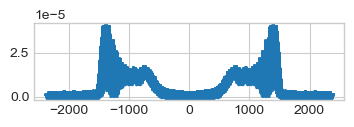

f =  1389.259256696966 [Hz]; v =  0.9508707801392564 [m/s]


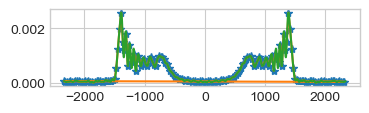

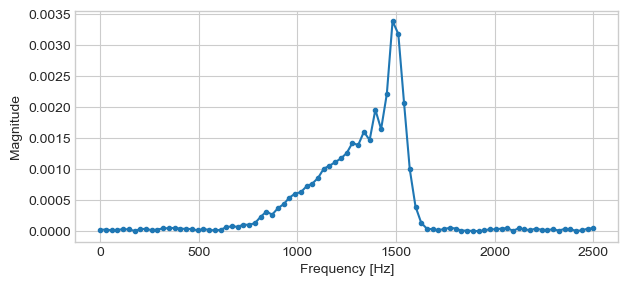

In [126]:
IQ_padded = np.concatenate([np.zeros(1000), I_sampled+Q_sampled, np. zeros(10000)])
t_sample2 = np.arange(len(IQ_padded))*t_sample[1]
freq2, spectrum2 = get_fft(t_sample2, IQ_padded)
f_doppler2 = abs(freq2[np.argmax(np.abs(spectrum2))])
velocity2 = f_doppler2*c/f_0/2/np.cos(theta*np.pi/180)
print("f = ",f_doppler2,"[Hz]; v = ",velocity2,"[m/s]")
plt.show()

IQ_os = I_sampled+Q_sampled
t_sample3 = np.arange(len(IQ_os))*t_sample[1]
freq3, spectrum3 = get_fft(t_sample3, IQ_os)
plt.plot(freq3,np.abs(spectrum3))
spectrum3 = ss.resample( np.abs(fft.fftshift(spectrum3)), len(spectrum3)*10,)
freq3 = np.arange(len(spectrum3))*(freq3[1]-freq3[0])/10+freq3[int(len(freq3)/2)]
f_doppler3 = abs(freq3[np.argmax(np.abs(spectrum3))])
velocity3 = f_doppler3*c/f_0/2/np.cos(theta*np.pi/180)
print("f = ",f_doppler3,"[Hz]; v = ",velocity3,"[m/s]")
plt.plot(freq3,np.abs(spectrum3))

plt.figure(figsize=(7,3))
IQ_padded = np.concatenate([np.zeros(1000), I_sampled+Q_sampled, np. zeros(10000)])*10000
#plt.magnitude_spectrum(IQ_padded,1/(t_sample[1]-t_sample[0]),scale='linear')

plt.magnitude_spectrum(I_sampled+Q_sampled,1/(t_sample[1]-t_sample[0]),marker='.',scale='linear')
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")

plt.savefig("sim_spectrum.pdf")
plt.show()

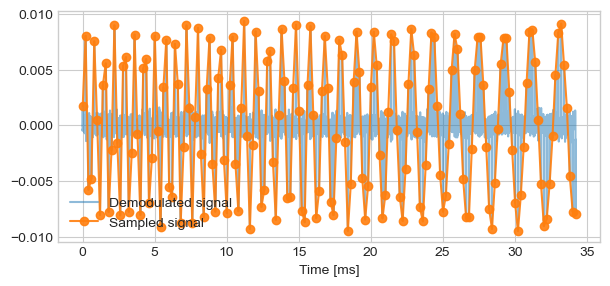

In [144]:
#plt.plot(t,echo/8)
plt.figure(figsize=(7,3))
plt.plot(t*1e3,I,label="Demodulated signal",alpha=.5)

plt.plot(t_sample*1e3,I_sampled,'o-',label="Sampled signal",alpha=0.9)
plt.legend()
#plt.plot(t,Q)
plt.xlabel("Time [ms]")
#plt.plot(t_sample,Q_sampled)
#plt.ylim(-3e-3,3e-3)
#plt.xlim(0,5e-3)
plt.savefig("sim_demod_sample.pdf")

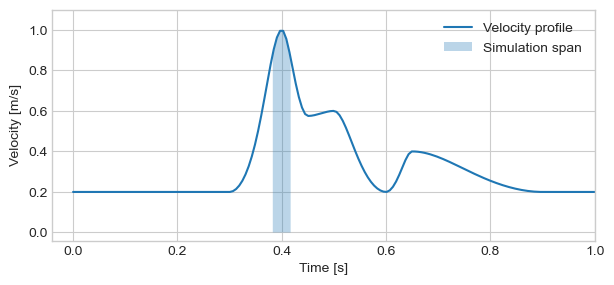

In [142]:
plt.figure(figsize=(7,3))

plt.plot(X,flow_function_cyclic(X),label="Velocity profile")

plt.fill_between(t+start_time,t*0,flow_function_cyclic(t+start_time),label="Simulation span",alpha=.3)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.xlim(-0.04,1)
plt.ylim(-0.04,1.1)
plt.savefig("simspan")